<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, PCA, KernelPCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 1. About the Data

## Importing the dataset

In [2]:
filepath = "Reviews.csv"
data = pd.read_csv(filepath, encoding='latin1')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Dataset Summary
This dataset is composed of thousands of Amazon Review for Fine Food Products. It includes the following features:
- ProductID and UserID: Used to identify the unique review (not needed for this analysis)
- Profile Name: Pretty self-explanatory (not needed again)
- Helpfulness Numerator/Denominator: People who have determined whether the review was helpful or not.
- Score: The score given by the user to the product.
- Time: Self-explanatory (also not needed)
- Summary: Gives a summary of the review in 5 words or less
- Text: Full review of the product (makes analysis slightly overcomplicated, so summary will be used instead)


## Objective of the Analysis
It is often important for all business owners to receive feedback about their products. It is even more important that they know what factors comprise a successful one. Therefore, the main objective of this analysis is to use unsupervised clustering and dimensionality reduction algorithms to determine what makes a five star review. This will be done by looking at the summaries of every review and determining what words correlate to successful products, giving entrepreneurs an idea of what to focus on when branding and manufacturing.

In [3]:
#Creating a helpfulness fraction column
def fraction_conversion(numerator, denominator):
    return round((numerator/denominator), 2)
data['helpful_fraction'] = fraction_conversion(data['HelpfulnessNumerator'], data['HelpfulnessDenominator'])
#Only keeping reviews that are > 80% helpful
data = data.dropna(subset=['helpful_fraction'])
data = data[data['helpful_fraction'] >= 0.9]

#Drop any rows with na cols
data = data.dropna()

import re
#Processing the string-based columns so that they can be easily processed
def string_conversion(string):
    stopwords = ['a', 'and', 'the', 'or', 'but', 'because', 'then', 'in', 'is', 'it', 'to', 'for', 'my', 'of', 'too',
                 'very', 'you', 'your', 'an', 'are', 'as', 'at', 'all', 'was', 'way', 'what', 'with', 'be', 'from', 
                 'get', 'if', 'its', 'just', 'me', 'our', 'so', 'than', 'that', 'them', 'these', 'they', 'this', 'up']
    #Lowercase everything
    string = string.lower()
    #Remove any special characters
    string = re.sub(r'[^a-zA-Z\s]', "", string)
    #Removing all common words in the stopwords list
    pattern = r'\b(' + r'|'.join(stopwords) + r')\b'
    string = re.sub(pattern, '', string)
    return string
data['Summary'] = data['Summary'].apply(string_conversion)
data['Text'] = data['Text'].apply(string_conversion)

#Removing the unimportant features
data = data.drop(columns=['Id', 'ProductId', 'ProfileName', 'UserId', 'Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'helpful_fraction'])

#Keep only 10000 rows don't need so many
data = data.iloc[0:10000, :]

## Data Cleaning and Feature Engineering
In order for this data to be used as effectively as possible, the following measures were taken:
1. To combat useless reviews, all instances with a helpfulness fraction of less than 0.9 were removed from the dataframe.
2. The summaries were processed with the following tactics: Removal of common stopwords, Removal of any special characters
3. Most of the columns were not useful in our analysis, so we kept score, summary, and text and discarded the rest.
4. Finally, there were so many rows that my computer was having a difficult time storing all of them, so only the first 10000 were kept.

# 2. Model Construction & Testing

## Tf-idf dataframe creation
The first step of doing any kind of word-processing unsupervised ML Model is to create a term-frequency inverse document frequency matrix, which below I have created a visual of as a dataframe. 
<br/><br/>
Additionally, all words in this dataframe must have occured in at least 0.5% of the reviews, this ensures that any infrequent typos that distort the data were removed.

In [4]:
#Creating the array of summaries
summaries = list(data['Summary'])

#Creating the tf-idf matrix
cv = CountVectorizer(min_df=0.005)
tf_mat = cv.fit_transform(summaries)
tf = pd.DataFrame(tf_mat.toarray(), columns=cv.get_feature_names_out())
tdif_trans = TfidfTransformer()
tfidf_mat = tdif_trans.fit_transform(tf)
tfidf = pd.DataFrame(tfidf_mat.toarray(), columns=tdif_trans.get_feature_names_out())
tfidf

,alternative,amazing,awesome,baby,bad,best,better,bread,buy,can,...,tea,toy,treat,treats,value,will,wonderful,works,yum,yummy
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.541604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimensionality Reduction
81 Dimensions is quite a significant calculation for any clustering algorithm. Therefore, PCA was applied to determine the best number of dimensions to reduce this dataframe to while still preserving a significant percentage of the variance. In the end, 20 components seemed to capture roughly 55% of the overall variance. Given some of the obscure words that were found in the original tf-idf matrix, this is more than enough.

[Text(0.5, 0, 'n_components'), Text(0, 0.5, 'error')]

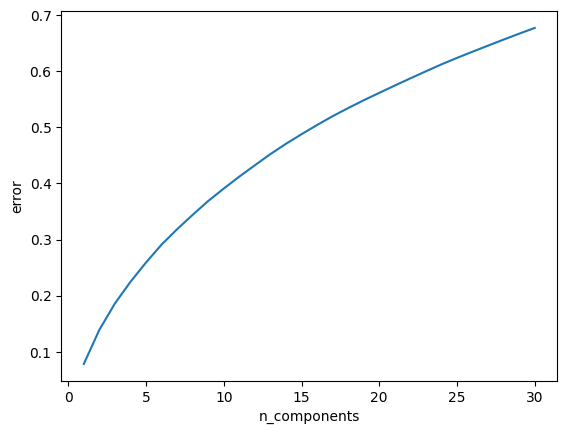

In [5]:
#Performing NMF on the tf-idf DataFrame and determining a best k
pca = PCA(n_components=30)
x_trans = pca.fit_transform(tfidf_mat)
explained_variance = pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots()
ax.plot(range(1, len(explained_variance)+1), explained_variance)
ax.set(xlabel='n_components', ylabel='error')
#Seems like around 20 is the elbow point

Below the optimized PCA was performed and the true distribution of five star reviews was calculated. This number is what we'll be aiming for in our clustering models.

In [6]:
#Build and get optimized PCA and transform the original data
optimized_pca = PCA(n_components=20)
new_x = optimized_pca.fit_transform(tfidf_mat)
new_df = pd.DataFrame(new_x, columns=optimized_pca.get_feature_names_out())

true_distribtion = [0 if x < 5 else 1 for x in data['Score']]
true_distribtion_frac = len([x for x in data['Score'] if x == 1])/len(data['Score'])
print(f'The fraction of reviews that are 5 stars is: {true_distribtion_frac:.2f}')

The fraction of reviews that are 5 stars is: 0.05


In [7]:
#KMeans model
kmeans = KMeans(n_clusters=2, init='k-means++')
predictions = kmeans.fit_predict(new_df)

pred_distribtion_frac = len([x for x in predictions if x == 1])/len(predictions)
print(f'The fraction of reviews that are 5 stars is: {pred_distribtion_frac:.2f}')

The fraction of reviews that are 5 stars is: 0.91


In [8]:
#Hierarchical Clustering Model
agglom = AgglomerativeClustering(n_clusters=2, linkage='ward')
predictions = agglom.fit_predict(new_df)

pred_distribtion_frac = len([x for x in predictions if x == 1])/len(predictions)
print(f'The fraction of reviews that are 5 stars is: {pred_distribtion_frac:.2f}')

The fraction of reviews that are 5 stars is: 0.08


In [9]:
dbs = DBSCAN(eps=0.3, min_samples=600)
predictions = dbs.fit_predict(new_df)

pred_distribtion_frac = len([x for x in predictions if x == 1])/len(predictions)
print(f'The fraction of reviews that are 5 stars is: {pred_distribtion_frac:.2f}')

The fraction of reviews that are 5 stars is: 0.04


## Summary of the models
All of the models performed relatively well in terms of producing a similar ratio of five star reviews, but here are some other notes based on the algorithms themselves that may have impacted performance:
1. KMeans algorithm: KMeans tends to find evenly sized clusters, and since the five star cluster in theory should only be 5%, it struggled to find the true clusters.
2. Hierarchical Algorithm: Overall did pretty well, works better on uneven cluster sizes. However, the large amount of data did make it the slowest out of the three.
3. DBSCAN: Responded to the difficulties of both KMeans and Hierarchical. Worked well in finding uneven cluster sizes and was very effective with the large amount of data presented to it.

## Final Prediction:
Given the situation that this model presents, the best model for the purpose identified above is DBSCAN. 

C:\Users\sslaq\AppData\Local\Temp\ipykernel_35712\2284456102.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(most_important.columns, rotation=90)


[Text(0, 0, 'amazing'),
 Text(1, 0, 'awesome'),
 Text(2, 0, 'best'),
 Text(3, 0, 'better'),
 Text(4, 0, 'coffee'),
 Text(5, 0, 'delicious'),
 Text(6, 0, 'dog'),
 Text(7, 0, 'ever'),
 Text(8, 0, 'excellent'),
 Text(9, 0, 'favorite'),
 Text(10, 0, 'good'),
 Text(11, 0, 'great'),
 Text(12, 0, 'like'),
 Text(13, 0, 'love'),
 Text(14, 0, 'loves'),
 Text(15, 0, 'nice'),
 Text(16, 0, 'not'),
 Text(17, 0, 'perfect'),
 Text(18, 0, 'price'),
 Text(19, 0, 'product'),
 Text(20, 0, 'stuff'),
 Text(21, 0, 'sweet'),
 Text(22, 0, 'tasty'),
 Text(23, 0, 'wonderful'),
 Text(24, 0, 'yum'),
 Text(25, 0, 'yummy')]

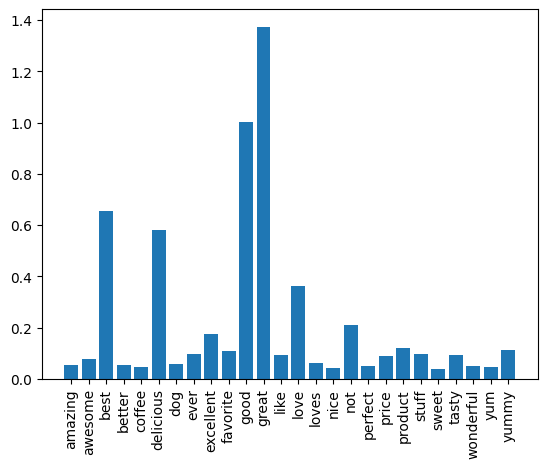

In [10]:
#Get the importance of each original component in the new model into a df
feature_importances = pd.DataFrame({
    'PCA1': optimized_pca.components_[0],
    'PCA2': optimized_pca.components_[1],
    'PCA3': optimized_pca.components_[2],
    'PCA4': optimized_pca.components_[3],
})
feature_importances = feature_importances.T
feature_importances = pd.DataFrame(feature_importances.sum())
feature_importances.set_index(tfidf.columns, inplace=True)
#Plot their importances accordingly
most_important = feature_importances[abs(feature_importances[0]) > 0.04].T
fig, ax = plt.subplots()
ax.bar(x=most_important.columns, height=abs(most_important.iloc[0, :]))  
ax.set_xticklabels(most_important.columns, rotation=90)

## Summary of Key Findings
To get some insight behind the modified data that was used as input into the DBSCAN model, the words that were most critical in the dimensionality reduced data was identified and plotted above. From this we can draw the following conclusions:
- The obvious indicators of good and bad reviews stood out. Descriptive words such as good, great, delicous, love, not, and perfect were some of the main indicators.
- Price is a huge factor in both directions, and customers seem to appreciate good value.
- Above all else, the taste of the food is what ruled all. Therefore, food entrepreneurs know that the quality of the product they sell will directly impact their reviews and sales more than packaging, distribution time, etc.

## Next Steps
The only next steps that I would suggest from this dataset is to find a way to more evenly sample the data so that the algorithms that do better on evenly sized clusters would produce more accurate results. This could be done with under/oversampling techniques learned previously in the course.